In [4]:
from google.colab import files
uploadtrain =  files.upload()

Saving Sheep Range Blackbrush.csv to Sheep Range Blackbrush.csv
Saving Sheep Range Mojave Desert Shrub.csv to Sheep Range Mojave Desert Shrub.csv
Saving Sheep Range Montane.csv to Sheep Range Montane.csv
Saving Sheep Range Pinyon-Juniper.csv to Sheep Range Pinyon-Juniper.csv
Saving Snake Range East Sagebrush.csv to Snake Range East Sagebrush.csv
Saving Snake Range East Salt Desert Shrub.csv to Snake Range East Salt Desert Shrub.csv
Saving Snake Range East Subalpine.csv to Snake Range East Subalpine.csv
Saving Snake Range West Montane.csv to Snake Range West Montane.csv
Saving Snake Range West Pinyon-Juniper.csv to Snake Range West Pinyon-Juniper.csv
Saving Snake Range West Sagebrush.csv to Snake Range West Sagebrush.csv
Saving Snake Range West Subalpine.csv to Snake Range West Subalpine.csv


In [0]:
import io
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [6]:
df_SnakeRWSub = pd.read_csv(io.BytesIO(uploadtrain['Snake Range West Subalpine.csv']))
df_SnakeRWSub.columns = ['timestamp', 'wind_speed']

#Convert the timestamp to actual date time data type
time = pd.to_datetime(df_SnakeRWSub.timestamp)
data_SnakeRWSub = pd.DataFrame(time)
data_SnakeRWSub['wind_speed'] = df_SnakeRWSub['wind_speed']
data_SnakeRWSub = data_SnakeRWSub.set_index(['timestamp'])
data_SnakeRWSub.head()

,wind_speed
timestamp,
2018-01-01 00:10:00-08:00,3.705962
2018-01-01 00:20:00-08:00,4.497222
2018-01-01 00:30:00-08:00,3.965245
2018-01-01 00:40:00-08:00,4.287114
2018-01-01 00:50:00-08:00,3.411362


In [7]:
print(data_SnakeRWSub.describe())

         wind_speed
count  47467.000000
mean       3.000161
std        1.649862
min        0.000000
25%        1.770278
50%        2.734097
75%        4.009949
max       12.338304


In [8]:
data_SnakeRWSub = data_SnakeRWSub.replace('?',np.NaN)

print('Number of instances = %d' % (data_SnakeRWSub.shape[0]))
print('Number of attributes = %d' % (data_SnakeRWSub.shape[1]))

print('Number of missing values:')
for col in data_SnakeRWSub.columns:
    print('\t%s: %d' % (col, data_SnakeRWSub[col].isna().sum()))

Number of instances = 52487
Number of attributes = 1
Number of missing values:
	wind_speed: 5020


In [9]:
data_SnakeRWSub =  data_SnakeRWSub.fillna(method = 'ffill')
print(data_SnakeRWSub.describe())

         wind_speed
count  52487.000000
mean       2.985210
std        1.709701
min        0.000000
25%        1.749268
50%        2.738567
75%        4.005478
max       12.338304


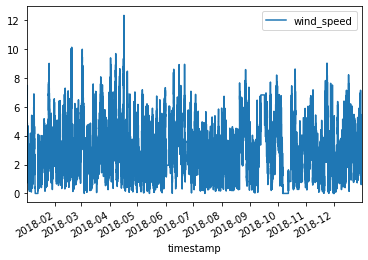

In [10]:
data_SnakeRWSub.plot()

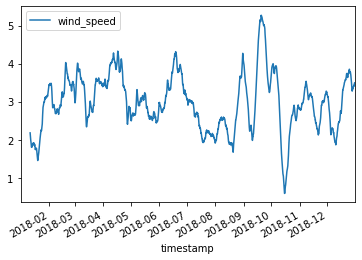

In [11]:
dataSnakeRWSub_mean = data_SnakeRWSub.rolling(window = 1500).mean()
dataSnakeRWSub_mean.plot()

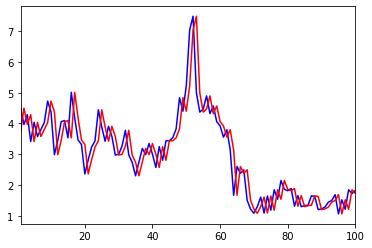

In [12]:
#Use the persistence model as a baseline model
#The first step is to load the dataset and create a lagged representation. 
#That is, given the observation at t-1, predict the observation at t+1
series_DataSnakeRWSub_value = data_SnakeRWSub.values
value_DataSnakeRWSub = pd.DataFrame(series_DataSnakeRWSub_value)
#persistence model
#dataframe.shift
wind_speed1 = pd.concat([value_DataSnakeRWSub, value_DataSnakeRWSub.shift(1)], axis = 1)
wind_speed1.columns = (['Actual', 'Predicted'])
windspeed_DataSnakeRWSub = wind_speed1[1:]

#plots of actual and predicted values
windspeed_DataSnakeRWSub['Actual'].head(100).plot(color='blue')
windspeed_DataSnakeRWSub['Predicted'].head(100).plot(color='red')

In [13]:
#persistence model mean squared error, root mean squared error, and mean absolute error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

windError_DataSnakeRWSub = mean_squared_error(windspeed_DataSnakeRWSub['Actual'], windspeed_DataSnakeRWSub['Predicted'])
mae_DataSnakeRWSub = mean_absolute_error(windspeed_DataSnakeRWSub['Actual'], windspeed_DataSnakeRWSub['Predicted'])
print("Mean squared error is: ", windError_DataSnakeRWSub)
print("Root mean squared error is: ", np.sqrt(windError_DataSnakeRWSub))
print("Mean absolute error is: ", mae_DataSnakeRWSub)

Mean squared error is:  0.22739893143610382
Root mean squared error is:  0.47686364029573886
Mean absolute error is:  0.3343006786724079


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


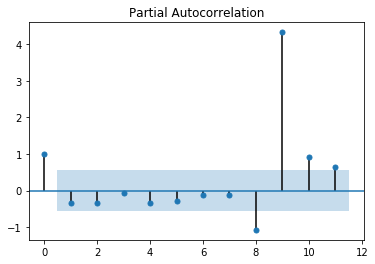

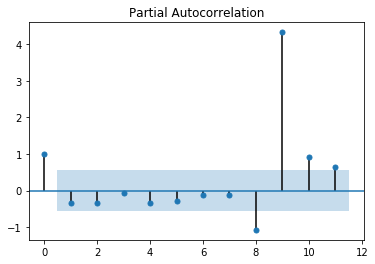

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

#Auto Regressive Model: A Stage of ARIMA implementation
#pacf is used to find the value of p
#find the value of p
#only one point is not in the critical portion

#resampling the data month-wise gives the lowest error
resampledData_SnakeRWSub = data_SnakeRWSub.resample('M').mean()
plot_pacf(resampledData_SnakeRWSub)

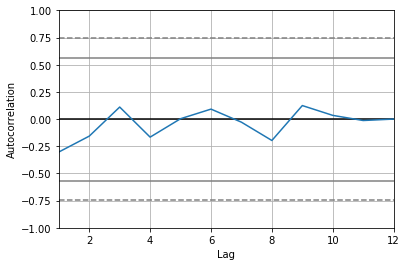

In [15]:
#Moving Average Model: A Stage of ARIMA implementation

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

#acf is used to find the value of q
autocorrelation_plot(resampledData_SnakeRWSub)
#from the graph below the value of q is zero ( no point is above the critical line)

In [16]:
#ARIMA model implementation
#d is the value where the data gets stationary
from statsmodels.tsa.arima_model import ARIMA

#parameter tuning
#from the previous AR and MA plots and knowing that our data is stationary, pdq values will be (1,0,0) respectively
modelData_SnakeRWSub = ARIMA(resampledData_SnakeRWSub, order = (1,0,0))
modelFitData_SnakeRWSub = modelData_SnakeRWSub.fit(disp = 0)
#residual error is observed minus predicted
residualsData_SnakeRWSub = pd.DataFrame(modelFitData_SnakeRWSub.resid)

forecastedData_SnakeRWSub = modelFitData_SnakeRWSub.forecast(steps = len(resampledData_SnakeRWSub))[0]
predictionsData_SnakeRWSub = pd.DataFrame(forecastedData_SnakeRWSub)
predictionsData_SnakeRWSub.columns = ['predictions']
predData_SnakeRWSub = pd.DataFrame(predictionsData_SnakeRWSub.values)
actualData_SnakeRWSub = pd.DataFrame(resampledData_SnakeRWSub.wind_speed.values)
predData_SnakeRWSub.columns = ['predicted']
actualData_SnakeRWSub.columns = ['actual']
f_predictionsData_SnakeRWSub = pd.merge(actualData_SnakeRWSub, predData_SnakeRWSub, left_index = True, right_index = True)
#Actual vs. Predicted
print(f_predictionsData_SnakeRWSub)

      actual  predicted
0   2.510571   2.982336
1   3.173340   3.005051
2   3.257146   2.998005
3   3.555894   3.000191
4   2.858420   2.999513
5   3.426403   2.999723
6   2.257299   2.999658
7   2.872519   2.999678
8   3.714915   2.999672
9   2.363225   2.999674
10  2.848219   2.999673
11  3.055567   2.999673


In [17]:
from sklearn.metrics import mean_absolute_error

errorData_SnakeRWSub = mean_squared_error(predictionsData_SnakeRWSub.values, resampledData_SnakeRWSub.wind_speed.values)
maeData_SnakeRWSub = mean_absolute_error(f_predictionsData_SnakeRWSub.actual, f_predictionsData_SnakeRWSub.predicted)
print("The Mean Squared Error is: ", errorData_SnakeRWSub)
print("The Root Mean Squared Error is: ", np.sqrt(errorData_SnakeRWSub))
print("The Mean Absolute Error is: ", maeData_SnakeRWSub)

The Mean Squared Error is:  0.19489781595075129
The Root Mean Squared Error is:  0.44147232750281334
The Mean Absolute Error is:  0.37093556517428933


In [18]:
df_SnakeRWSage = pd.read_csv(io.BytesIO(uploadtrain['Snake Range West Sagebrush.csv']))
df_SnakeRWSage.columns = ['timestamp', 'wind_speed']

#Convert the timestamp to actual date time data type
time = pd.to_datetime(df_SnakeRWSage.timestamp)
data_SnakeRWSage = pd.DataFrame(time)
data_SnakeRWSage['wind_speed'] = df_SnakeRWSage['wind_speed']
data_SnakeRWSage = data_SnakeRWSage.set_index(['timestamp'])
data_SnakeRWSage.head()

,wind_speed
timestamp,
2018-01-01 00:10:00-08:00,1.583416
2018-01-01 00:20:00-08:00,2.235647
2018-01-01 00:30:00-08:00,2.032244
2018-01-01 00:40:00-08:00,0.916879
2018-01-01 00:50:00-08:00,0.445252


In [19]:
print(data_SnakeRWSage.describe())

         wind_speed
count  47719.000000
mean       2.994064
std        2.249220
min        0.000000
25%        1.384930
50%        2.399711
75%        4.014419
max       16.504717


In [20]:
data_SnakeRWSage = data_SnakeRWSage.replace('?',np.NaN)

print('Number of instances = %d' % (data_SnakeRWSage.shape[0]))
print('Number of attributes = %d' % (data_SnakeRWSage.shape[1]))

print('Number of missing values:')
for col in data_SnakeRWSage.columns:
    print('\t%s: %d' % (col, data_SnakeRWSage[col].isna().sum()))

Number of instances = 52487
Number of attributes = 1
Number of missing values:
	wind_speed: 4768


In [21]:
data_SnakeRWSage =  data_SnakeRWSage.fillna(method = 'ffill')
print(data_SnakeRWSage.describe())

         wind_speed
count  52487.000000
mean       3.134518
std        2.342585
min        0.000000
25%        1.451092
50%        2.523094
75%        4.184294
max       16.504717


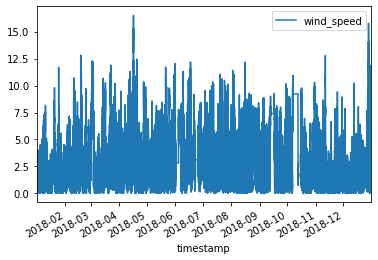

In [22]:
data_SnakeRWSage.plot()

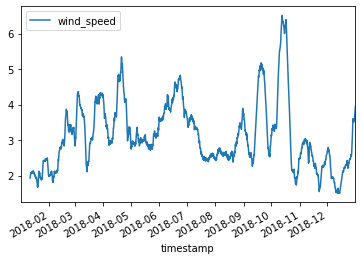

In [23]:
dataSnakeRWSage_mean = data_SnakeRWSage.rolling(window = 1500).mean()
dataSnakeRWSage_mean.plot()

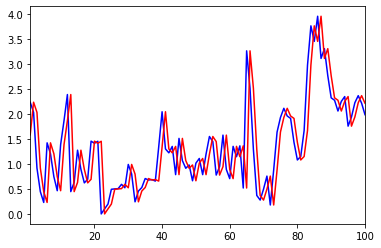

In [24]:
#Use the persistence model as a baseline model
#The first step is to load the dataset and create a lagged representation. 
#That is, given the observation at t-1, predict the observation at t+1
series_DataSnakeRWSage_value = data_SnakeRWSage.values
value_DataSnakeRWSage = pd.DataFrame(series_DataSnakeRWSage_value)
#persistence model
#dataframe.shift
wind_speed2 = pd.concat([value_DataSnakeRWSage, value_DataSnakeRWSage.shift(1)], axis = 1)
wind_speed2.columns = (['Actual', 'Predicted'])
windspeed_DataSnakeRWSage = wind_speed2[1:]

#plots of actual and predicted values
windspeed_DataSnakeRWSage['Actual'].head(100).plot(color='blue')
windspeed_DataSnakeRWSage['Predicted'].head(100).plot(color='red')

In [25]:
#persistence model mean squared error, root mean squared error, and mean absolute error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

windError_DataSnakeRWSage = mean_squared_error(windspeed_DataSnakeRWSage['Actual'], windspeed_DataSnakeRWSage['Predicted'])
mae_DataSnakeRWSage = mean_absolute_error(windspeed_DataSnakeRWSage['Actual'], windspeed_DataSnakeRWSage['Predicted'])
print("Mean squared error is: ", windError_DataSnakeRWSage)
print("Root mean squared error is: ", np.sqrt(windError_DataSnakeRWSage))
print("Mean absolute error is: ", mae_DataSnakeRWSage)

Mean squared error is:  0.5168778698982056
Root mean squared error is:  0.7189421881474237
Mean absolute error is:  0.4995622344030789


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


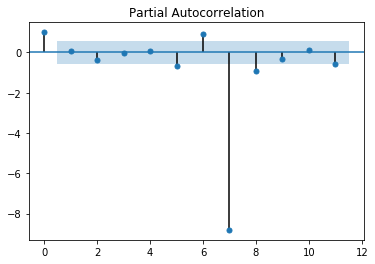

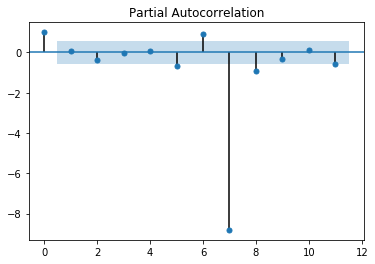

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf

#Auto Regressive Model: A Stage of ARIMA implementation
#pacf is used to find the value of p
#find the value of p
#only one point is not in the critical portion

#resampling the data month-wise gives the lowest error
resampledData_SnakeRWSage = data_SnakeRWSage.resample('M').mean()
plot_pacf(resampledData_SnakeRWSage)

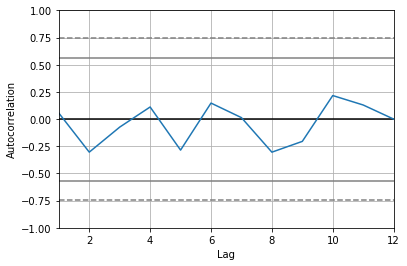

In [27]:
#Moving Average Model: A Stage of ARIMA implementation

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

#acf is used to find the value of q
autocorrelation_plot(resampledData_SnakeRWSage)
#from the graph below the value of q is zero (no point is above the critical line)

In [28]:
#ARIMA model implementation
#d is the value where the data gets stationary
from statsmodels.tsa.arima_model import ARIMA

#parameter tuning
#from the previous AR and MA plots and knowing that our data is stationary, pdq values will be (1,0,0) respectively
modelData_SnakeRWSage = ARIMA(resampledData_SnakeRWSage, order = (1,0,0))
modelFitData_SnakeRWSage = modelData_SnakeRWSage.fit(disp = 0)
#residual error is observed minus predicted
residualsData_SnakeRWSage = pd.DataFrame(modelFitData_SnakeRWSage.resid)

forecastedData_SnakeRWSage = modelFitData_SnakeRWSage.forecast(steps = len(resampledData_SnakeRWSage))[0]
predictionsData_SnakeRWSage = pd.DataFrame(forecastedData_SnakeRWSage)
predictionsData_SnakeRWSage.columns = ['predictions']
predData_SnakeRWSage = pd.DataFrame(predictionsData_SnakeRWSage.values)
actualData_SnakeRWSage = pd.DataFrame(resampledData_SnakeRWSage.wind_speed.values)
predData_SnakeRWSage.columns = ['predicted']
actualData_SnakeRWSage.columns = ['actual']
f_predictionsData_SnakeRWSage = pd.merge(actualData_SnakeRWSage, predData_SnakeRWSage, left_index = True, right_index = True)
#Actual vs. Predicted
print(f_predictionsData_SnakeRWSage)

      actual  predicted
0   2.002486   3.083486
1   2.921615   3.120239
2   3.706928   3.123180
3   3.710511   3.123415
4   3.129131   3.123434
5   4.034622   3.123435
6   2.752299   3.123435
7   2.970525   3.123435
8   3.562957   3.123435
9   3.829243   3.123435
10  2.377641   3.123435
11  2.624191   3.123435


In [29]:
from sklearn.metrics import mean_absolute_error

errorData_SnakeRWSage = mean_squared_error(predictionsData_SnakeRWSage.values, resampledData_SnakeRWSage.wind_speed.values)
maeData_SnakeRWSage = mean_absolute_error(f_predictionsData_SnakeRWSage.actual, f_predictionsData_SnakeRWSage.predicted)
print("The Mean Squared Error is: ", errorData_SnakeRWSage)
print("The Root Mean Squared Error is: ", np.sqrt(errorData_SnakeRWSage))
print("The Mean Absolute Error is: ", maeData_SnakeRWSage)

The Mean Squared Error is:  0.36513939509925747
The Root Mean Squared Error is:  0.6042676518722953
The Mean Absolute Error is:  0.5234806228085312


In [30]:
df_SnakeRWJuniper = pd.read_csv(io.BytesIO(uploadtrain['Snake Range West Pinyon-Juniper.csv']))
df_SnakeRWJuniper.columns = ['timestamp', 'wind_speed']

#Convert the timestamp to actual date time data type
time = pd.to_datetime(df_SnakeRWJuniper.timestamp)
data_SnakeRWJuniper = pd.DataFrame(time)
data_SnakeRWJuniper['wind_speed'] = df_SnakeRWJuniper['wind_speed']
data_SnakeRWJuniper = data_SnakeRWJuniper.set_index(['timestamp'])
data_SnakeRWJuniper.head()

,wind_speed
timestamp,
2018-01-01 00:10:00-08:00,0.379537
2018-01-01 00:20:00-08:00,0.404571
2018-01-01 00:30:00-08:00,0.760415
2018-01-01 00:40:00-08:00,1.604427
2018-01-01 00:50:00-08:00,0.852952


In [31]:
print(data_SnakeRWJuniper.describe())

         wind_speed
count  47466.000000
mean       2.097238
std        1.810984
min        0.000000
25%        0.932972
50%        1.653601
75%        2.602667
max       18.981318


In [32]:
data_SnakeRWJuniper = data_SnakeRWJuniper.replace('?',np.NaN)

print('Number of instances = %d' % (data_SnakeRWJuniper.shape[0]))
print('Number of attributes = %d' % (data_SnakeRWJuniper.shape[1]))

print('Number of missing values:')
for col in data_SnakeRWJuniper.columns:
    print('\t%s: %d' % (col, data_SnakeRWJuniper[col].isna().sum()))

Number of instances = 52487
Number of attributes = 1
Number of missing values:
	wind_speed: 5021


In [33]:
data_SnakeRWJuniper =  data_SnakeRWJuniper.fillna(method = 'ffill')
print(data_SnakeRWJuniper.describe())

         wind_speed
count  52487.000000
mean       2.226333
std        2.004723
min        0.000000
25%        0.955101
50%        1.700987
75%        2.690957
max       18.981318


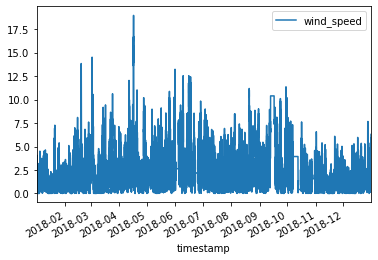

In [34]:
data_SnakeRWJuniper.plot()

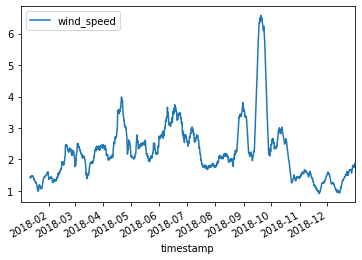

In [35]:
dataSnakeRWJuniper_mean = data_SnakeRWJuniper.rolling(window = 1500).mean()
dataSnakeRWJuniper_mean.plot()

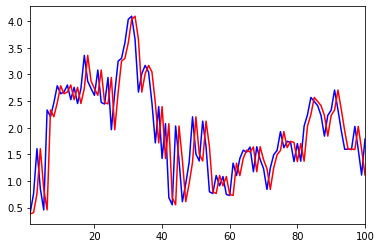

In [37]:
#Use the persistence model as a baseline model
#The first step is to load the dataset and create a lagged representation. 
#That is, given the observation at t-1, predict the observation at t+1
series_DataSnakeRWJuniper_value = data_SnakeRWJuniper.values
value_DataSnakeRWJuniper = pd.DataFrame(series_DataSnakeRWJuniper_value)
#persistence model
#dataframe.shift
wind_speed3 = pd.concat([value_DataSnakeRWJuniper, value_DataSnakeRWJuniper.shift(1)], axis = 1)
wind_speed3.columns = (['Actual', 'Predicted'])
windspeed_DataSnakeRWJuniper = wind_speed3[1:]

#plots of actual and predicted values
windspeed_DataSnakeRWJuniper['Actual'].head(100).plot(color='blue')
windspeed_DataSnakeRWJuniper['Predicted'].head(100).plot(color='red')

In [38]:
#persistence model mean squared error, root mean squared error, and mean absolute error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

windError_DataSnakeRWJuniper = mean_squared_error(windspeed_DataSnakeRWJuniper['Actual'], windspeed_DataSnakeRWJuniper['Predicted'])
mae_DataSnakeRWJuniper = mean_absolute_error(windspeed_DataSnakeRWJuniper['Actual'], windspeed_DataSnakeRWJuniper['Predicted'])
print("Mean squared error is: ", windError_DataSnakeRWJuniper)
print("Root mean squared error is: ", np.sqrt(windError_DataSnakeRWJuniper))
print("Mean absolute error is: ", mae_DataSnakeRWJuniper)

Mean squared error is:  0.44353048188309224
Root mean squared error is:  0.6659808419790259
Mean absolute error is:  0.45753980153488544


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


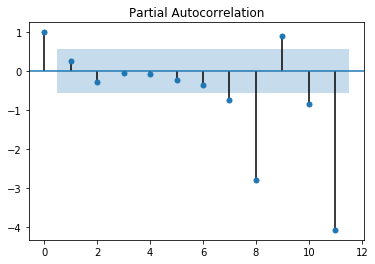

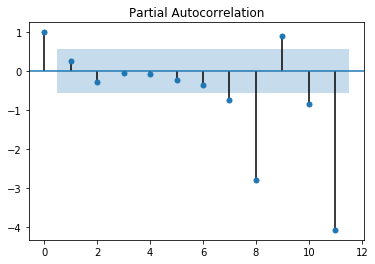

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf

#Auto Regressive Model: A Stage of ARIMA implementation
#pacf is used to find the value of p
#find the value of p
#only one point is not in the critical portion

#resampling the data month-wise gives the lowest error
resampledData_SnakeRWJuniper = data_SnakeRWJuniper.resample('M').mean()
plot_pacf(resampledData_SnakeRWJuniper)

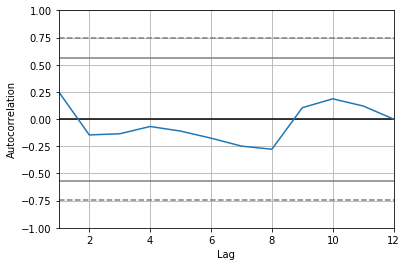

In [40]:
#Moving Average Model: A Stage of ARIMA implementation

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

#acf is used to find the value of q
autocorrelation_plot(resampledData_SnakeRWJuniper)
#from the graph below the value of q is zero (no point is above the critical line)

In [41]:
#ARIMA model implementation
#d is the value where the data gets stationary
from statsmodels.tsa.arima_model import ARIMA

#parameter tuning
#from the previous AR and MA plots and knowing that our data is stationary, pdq values will be (1,0,0) respectively
modelData_SnakeRWJuniper = ARIMA(resampledData_SnakeRWJuniper, order = (1,0,0))
modelFitData_SnakeRWJuniper = modelData_SnakeRWJuniper.fit(disp = 0)
#residual error is observed minus predicted
residualsData_SnakeRWJuniper = pd.DataFrame(modelFitData_SnakeRWJuniper.resid)

forecastedData_SnakeRWJuniper = modelFitData_SnakeRWJuniper.forecast(steps = len(resampledData_SnakeRWJuniper))[0]
predictionsData_SnakeRWJuniper = pd.DataFrame(forecastedData_SnakeRWJuniper)
predictionsData_SnakeRWJuniper.columns = ['predictions']
predData_SnakeRWJuniper = pd.DataFrame(predictionsData_SnakeRWJuniper.values)
actualData_SnakeRWJuniper = pd.DataFrame(resampledData_SnakeRWJuniper.wind_speed.values)
predData_SnakeRWJuniper.columns = ['predicted']
actualData_SnakeRWJuniper.columns = ['actual']
f_predictionsData_SnakeRWJuniper = pd.merge(actualData_SnakeRWJuniper, predData_SnakeRWJuniper, left_index = True, right_index = True)
#Actual vs. Predicted
print(f_predictionsData_SnakeRWJuniper)

      actual  predicted
0   1.336076   1.954543
1   1.883570   2.103377
2   2.174942   2.149565
3   2.736216   2.163899
4   2.385986   2.168347
5   3.045789   2.169728
6   2.093867   2.170156
7   2.600588   2.170289
8   3.693531   2.170330
9   1.955486   2.170343
10  1.351501   2.170347
11  1.474947   2.170348


In [42]:
from sklearn.metrics import mean_absolute_error

errorData_SnakeRWJuniper = mean_squared_error(predictionsData_SnakeRWJuniper.values, resampledData_SnakeRWJuniper.wind_speed.values)
maeData_SnakeRWJuniper = mean_absolute_error(f_predictionsData_SnakeRWJuniper.actual, f_predictionsData_SnakeRWJuniper.predicted)
print("The Mean Squared Error is: ", errorData_SnakeRWJuniper)
print("The Root Mean Squared Error is: ", np.sqrt(errorData_SnakeRWJuniper))
print("The Mean Absolute Error is: ", maeData_SnakeRWJuniper)

The Mean Squared Error is:  0.44043591668667115
The Root Mean Squared Error is:  0.6636534612933704
The Mean Absolute Error is:  0.5240467792146665


In [43]:
df_SnakeRWMontane = pd.read_csv(io.BytesIO(uploadtrain['Snake Range West Montane.csv']))
df_SnakeRWMontane.columns = ['timestamp', 'wind_speed']

#Convert the timestamp to actual date time data type
time = pd.to_datetime(df_SnakeRWMontane.timestamp)
data_SnakeRWMontane = pd.DataFrame(time)
data_SnakeRWMontane['wind_speed'] = df_SnakeRWMontane['wind_speed']
data_SnakeRWMontane = data_SnakeRWMontane.set_index(['timestamp'])
data_SnakeRWMontane.head()

,wind_speed
timestamp,
2018-01-01 00:10:00-08:00,2.465873
2018-01-01 00:20:00-08:00,2.485542
2018-01-01 00:30:00-08:00,2.517282
2018-01-01 00:40:00-08:00,2.754213
2018-01-01 00:50:00-08:00,2.867315


In [44]:
print(data_SnakeRWMontane.describe())

         wind_speed
count  47712.000000
mean       2.050171
std        1.403032
min        0.000000
25%        1.008075
50%        1.770725
75%        2.760025
max       11.654333


In [45]:
data_SnakeRWMontane = data_SnakeRWMontane.replace('?',np.NaN)

print('Number of instances = %d' % (data_SnakeRWMontane.shape[0]))
print('Number of attributes = %d' % (data_SnakeRWMontane.shape[1]))

print('Number of missing values:')
for col in data_SnakeRWMontane.columns:
    print('\t%s: %d' % (col, data_SnakeRWMontane[col].isna().sum()))

Number of instances = 52487
Number of attributes = 1
Number of missing values:
	wind_speed: 4775


In [46]:
data_SnakeRWMontane =  data_SnakeRWMontane.fillna(method = 'ffill')
print(data_SnakeRWMontane.describe())

         wind_speed
count  52487.000000
mean       2.043464
std        1.385094
min        0.000000
25%        0.991088
50%        1.781901
75%        2.785506
max       11.654333


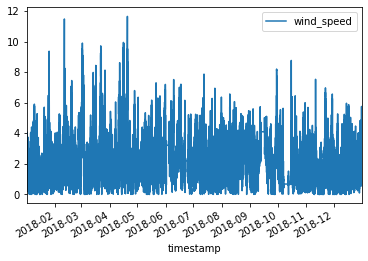

In [47]:
data_SnakeRWMontane.plot()

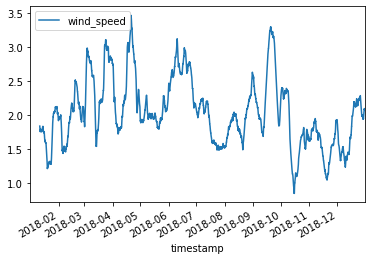

In [48]:
dataSnakeRWMontane_mean = data_SnakeRWMontane.rolling(window = 1500).mean()
dataSnakeRWMontane_mean.plot()

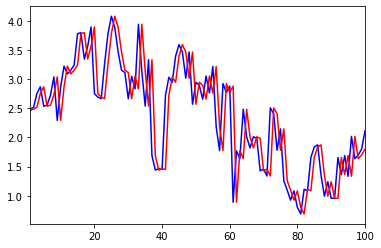

In [49]:
#Use the persistence model as a baseline model
#The first step is to load the dataset and create a lagged representation. 
#That is, given the observation at t-1, predict the observation at t+1
series_DataSnakeRWMontane_value = data_SnakeRWMontane.values
value_DataSnakeRWMontane = pd.DataFrame(series_DataSnakeRWMontane_value)
#persistence model
#dataframe.shift
wind_speed4 = pd.concat([value_DataSnakeRWMontane, value_DataSnakeRWMontane.shift(1)], axis = 1)
wind_speed4.columns = (['Actual', 'Predicted'])
windspeed_DataSnakeRWMontane = wind_speed4[1:]

#plots of actual and predicted values
windspeed_DataSnakeRWMontane['Actual'].head(100).plot(color='blue')
windspeed_DataSnakeRWMontane['Predicted'].head(100).plot(color='red')

In [50]:
#persistence model mean squared error, root mean squared error, and mean absolute error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

windError_DataSnakeRWMontane = mean_squared_error(windspeed_DataSnakeRWMontane['Actual'], windspeed_DataSnakeRWMontane['Predicted'])
mae_DataSnakeRWMontane = mean_absolute_error(windspeed_DataSnakeRWMontane['Actual'], windspeed_DataSnakeRWMontane['Predicted'])
print("Mean squared error is: ", windError_DataSnakeRWMontane)
print("Root mean squared error is: ", np.sqrt(windError_DataSnakeRWMontane))
print("Mean absolute error is: ", mae_DataSnakeRWMontane)

Mean squared error is:  0.3001787592697654
Root mean squared error is:  0.5478857173441971
Mean absolute error is:  0.3799292932606791


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


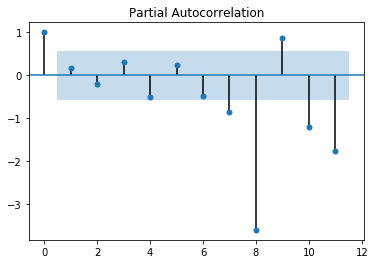

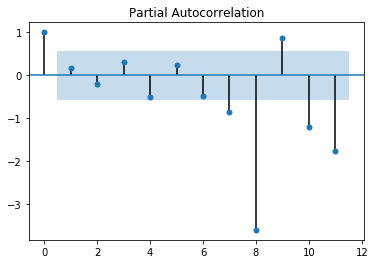

In [51]:
from statsmodels.graphics.tsaplots import plot_pacf

#Auto Regressive Model: A Stage of ARIMA implementation
#pacf is used to find the value of p
#find the value of p
#only one point is not in the critical portion

#resampling the data month-wise gives the lowest error
resampledData_SnakeRWMontane = data_SnakeRWMontane.resample('M').mean()
plot_pacf(resampledData_SnakeRWMontane)

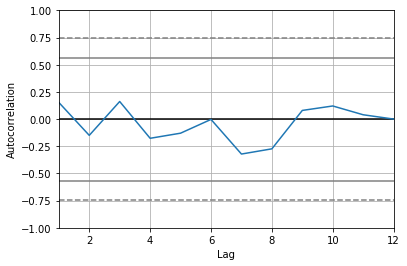

In [52]:
#Moving Average Model: A Stage of ARIMA implementation

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

#acf is used to find the value of q
autocorrelation_plot(resampledData_SnakeRWMontane)
#from the graph below the value of q is zero (no point is above the critical line)

In [53]:
#ARIMA model implementation
#d is the value where the data gets stationary
from statsmodels.tsa.arima_model import ARIMA

#parameter tuning
#from the previous AR and MA plots and knowing that our data is stationary, pdq values will be (1,0,0) respectively
modelData_SnakeRWMontane = ARIMA(resampledData_SnakeRWMontane, order = (1,0,0))
modelFitData_SnakeRWMontane = modelData_SnakeRWMontane.fit(disp = 0)
#residual error is observed minus predicted
residualsData_SnakeRWMontane = pd.DataFrame(modelFitData_SnakeRWMontane.resid)

forecastedData_SnakeRWMontane = modelFitData_SnakeRWMontane.forecast(steps = len(resampledData_SnakeRWMontane))[0]
predictionsData_SnakeRWMontane = pd.DataFrame(forecastedData_SnakeRWMontane)
predictionsData_SnakeRWMontane.columns = ['predictions']
predData_SnakeRWMontane = pd.DataFrame(predictionsData_SnakeRWMontane.values)
actualData_SnakeRWMontane = pd.DataFrame(resampledData_SnakeRWMontane.wind_speed.values)
predData_SnakeRWMontane.columns = ['predicted']
actualData_SnakeRWMontane.columns = ['actual']
f_predictionsData_SnakeRWMontane = pd.merge(actualData_SnakeRWMontane, predData_SnakeRWMontane, left_index = True, right_index = True)
#Actual vs. Predicted
print(f_predictionsData_SnakeRWMontane)

      actual  predicted
0   1.700426   2.011542
1   1.974815   2.032941
2   2.542714   2.036320
3   2.420329   2.036853
4   2.106778   2.036938
5   2.518332   2.036951
6   1.761624   2.036953
7   2.079348   2.036953
8   2.431060   2.036954
9   1.559132   2.036954
10  1.566132   2.036954
11  1.876043   2.036954


In [54]:
from sklearn.metrics import mean_absolute_error

errorData_SnakeRWMontane = mean_squared_error(predictionsData_SnakeRWMontane.values, resampledData_SnakeRWMontane.wind_speed.values)
maeData_SnakeRWMontane = mean_absolute_error(f_predictionsData_SnakeRWMontane.actual, f_predictionsData_SnakeRWMontane.predicted)
print("The Mean Squared Error is: ", errorData_SnakeRWMontane)
print("The Root Mean Squared Error is: ", np.sqrt(errorData_SnakeRWMontane))
print("The Mean Absolute Error is: ", maeData_SnakeRWMontane)

The Mean Squared Error is:  0.1207557368873915
The Root Mean Squared Error is:  0.3474992617076927
The Mean Absolute Error is:  0.3026431601580996


In [55]:
df_SnakeRESub = pd.read_csv(io.BytesIO(uploadtrain['Snake Range East Subalpine.csv']))
df_SnakeRESub.columns = ['timestamp', 'wind_speed']

#Convert the timestamp to actual date time data type
time = pd.to_datetime(df_SnakeRESub.timestamp)
data_SnakeRESub = pd.DataFrame(time)
data_SnakeRESub['wind_speed'] = df_SnakeRESub['wind_speed']
data_SnakeRESub = data_SnakeRESub.set_index(['timestamp'])
data_SnakeRESub.head()

,wind_speed
timestamp,
2018-01-01 00:10:00-08:00,0.628538
2018-01-01 00:20:00-08:00,0.675477
2018-01-01 00:30:00-08:00,0.665643
2018-01-01 00:40:00-08:00,0.903021
2018-01-01 00:50:00-08:00,0.907491


In [56]:
print(data_SnakeRESub.describe())

         wind_speed
count  36208.000000
mean       0.750445
std        0.428857
min        0.000000
25%        0.459557
50%        0.676372
75%        0.978124
max        3.067588


In [57]:
data_SnakeRESub = data_SnakeRESub.replace('?',np.NaN)

print('Number of instances = %d' % (data_SnakeRESub.shape[0]))
print('Number of attributes = %d' % (data_SnakeRESub.shape[1]))

print('Number of missing values:')
for col in data_SnakeRESub.columns:
    print('\t%s: %d' % (col, data_SnakeRESub[col].isna().sum()))

Number of instances = 41839
Number of attributes = 1
Number of missing values:
	wind_speed: 5631


In [58]:
data_SnakeRESub =  data_SnakeRESub.fillna(method = 'ffill')
print(data_SnakeRESub.describe())

         wind_speed
count  41839.000000
mean       0.714588
std        0.437720
min        0.000000
25%        0.416194
50%        0.658043
75%        0.956666
max        3.067588


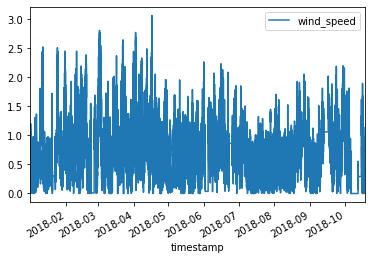

In [59]:
data_SnakeRESub.plot()

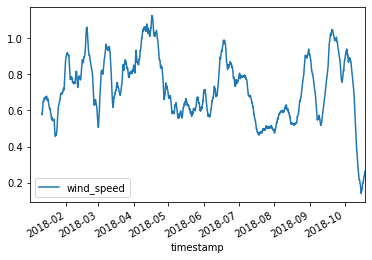

In [60]:
dataSnakeRESub_mean = data_SnakeRESub.rolling(window = 1500).mean()
dataSnakeRESub_mean.plot()

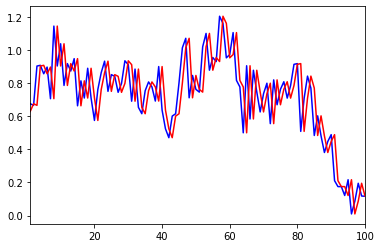

In [62]:
#Use the persistence model as a baseline model
#The first step is to load the dataset and create a lagged representation. 
#That is, given the observation at t-1, predict the observation at t+1
series_DataSnakeRESub_value = data_SnakeRESub.values
value_DataSnakeRESub = pd.DataFrame(series_DataSnakeRESub_value)
#persistence model
#dataframe.shift
wind_speed5 = pd.concat([value_DataSnakeRESub, value_DataSnakeRESub.shift(1)], axis = 1)
wind_speed5.columns = (['Actual', 'Predicted'])
windspeed_DataSnakeRESub = wind_speed5[1:]

#plots of actual and predicted values
windspeed_DataSnakeRESub['Actual'].head(100).plot(color='blue')
windspeed_DataSnakeRESub['Predicted'].head(100).plot(color='red')

In [63]:
#persistence model mean squared error, root mean squared error, and mean absolute error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

windError_DataSnakeRESub = mean_squared_error(windspeed_DataSnakeRESub['Actual'], windspeed_DataSnakeRESub['Predicted'])
mae_DataSnakeRESub = mean_absolute_error(windspeed_DataSnakeRESub['Actual'], windspeed_DataSnakeRESub['Predicted'])
print("Mean squared error is: ", windError_DataSnakeRESub)
print("Root mean squared error is: ", np.sqrt(windError_DataSnakeRESub))
print("Mean absolute error is: ", mae_DataSnakeRESub)

Mean squared error is:  0.03542435467106619
Root mean squared error is:  0.18821358790232492
Mean absolute error is:  0.1321844966126488


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


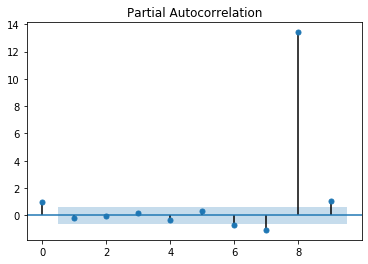

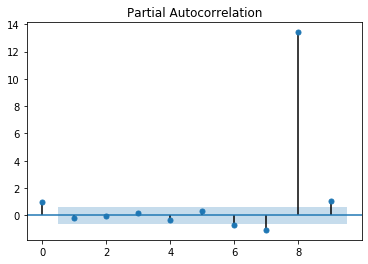

In [64]:
from statsmodels.graphics.tsaplots import plot_pacf

#Auto Regressive Model: A Stage of ARIMA implementation
#pacf is used to find the value of p
#find the value of p
#only one point is not in the critical portion

#resampling the data month-wise gives the lowest error
resampledData_SnakeRESub = data_SnakeRESub.resample('M').mean()
plot_pacf(resampledData_SnakeRESub)

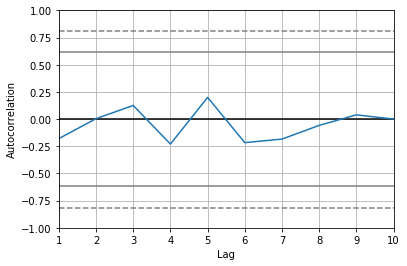

In [65]:
#Moving Average Model: A Stage of ARIMA implementation

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

#acf is used to find the value of q
autocorrelation_plot(resampledData_SnakeRESub)
#from the graph below the value of q is zero (no point is above the critical line)

In [66]:
#ARIMA model implementation
#d is the value where the data gets stationary
from statsmodels.tsa.arima_model import ARIMA

#parameter tuning
#from the previous AR and MA plots and knowing that our data is stationary, pdq values will be (1,0,0) respectively
modelData_SnakeRESub = ARIMA(resampledData_SnakeRESub, order = (1,0,0))
modelFitData_SnakeRESub = modelData_SnakeRESub.fit(disp = 0)
#residual error is observed minus predicted
residualsData_SnakeRESub = pd.DataFrame(modelFitData_SnakeRESub.resid)

forecastedData_SnakeRESub = modelFitData_SnakeRESub.forecast(steps = len(resampledData_SnakeRESub))[0]
predictionsData_SnakeRESub = pd.DataFrame(forecastedData_SnakeRESub)
predictionsData_SnakeRESub.columns = ['predictions']
predData_SnakeRESub = pd.DataFrame(predictionsData_SnakeRESub.values)
actualData_SnakeRESub = pd.DataFrame(resampledData_SnakeRESub.wind_speed.values)
predData_SnakeRESub.columns = ['predicted']
actualData_SnakeRESub.columns = ['actual']
f_predictionsData_SnakeRESub = pd.merge(actualData_SnakeRESub, predData_SnakeRESub, left_index = True, right_index = True)
#Actual vs. Predicted
print(f_predictionsData_SnakeRESub)

     actual  predicted
0  0.675274   0.810900
1  0.730702   0.678902
2  0.838197   0.719929
3  0.914548   0.707177
4  0.627354   0.711140
5  0.773918   0.709909
6  0.547125   0.710291
7  0.699860   0.710172
8  0.823706   0.710209
9  0.386219   0.710198


In [67]:
from sklearn.metrics import mean_absolute_error

errorData_SnakeRESub = mean_squared_error(predictionsData_SnakeRESub.values, resampledData_SnakeRESub.wind_speed.values)
maeData_SnakeRESub = mean_absolute_error(f_predictionsData_SnakeRESub.actual, f_predictionsData_SnakeRESub.predicted)
print("The Mean Squared Error is: ", errorData_SnakeRESub)
print("The Root Mean Squared Error is: ", np.sqrt(errorData_SnakeRESub))
print("The Mean Absolute Error is: ", maeData_SnakeRESub)

The Mean Squared Error is:  0.023375881382103458
The Root Mean Squared Error is:  0.1528917309147341
The Mean Absolute Error is:  0.12718159767917142


In [68]:
df_SnakeRESalt = pd.read_csv(io.BytesIO(uploadtrain['Snake Range East Salt Desert Shrub.csv']))
df_SnakeRESalt.columns = ['timestamp', 'wind_speed']

#Convert the timestamp to actual date time data type
time = pd.to_datetime(df_SnakeRESalt.timestamp)
data_SnakeRESalt = pd.DataFrame(time)
data_SnakeRESalt['wind_speed'] = df_SnakeRESalt['wind_speed']
data_SnakeRESalt = data_SnakeRESalt.set_index(['timestamp'])
data_SnakeRESalt.head()

,wind_speed
timestamp,
2018-01-01 00:10:00-08:00,3.221817
2018-01-01 00:20:00-08:00,3.281274
2018-01-01 00:30:00-08:00,3.239699
2018-01-01 00:40:00-08:00,3.607613
2018-01-01 00:50:00-08:00,3.422538


In [69]:
print(data_SnakeRESalt.describe())

         wind_speed
count  47986.000000
mean       4.118828
std        2.841801
min        0.000000
25%        2.116287
50%        3.367776
75%        5.351069
max       20.161504


In [70]:
data_SnakeRESalt = data_SnakeRESalt.replace('?',np.NaN)

print('Number of instances = %d' % (data_SnakeRESalt.shape[0]))
print('Number of attributes = %d' % (data_SnakeRESalt.shape[1]))

print('Number of missing values:')
for col in data_SnakeRESalt.columns:
    print('\t%s: %d' % (col, data_SnakeRESalt[col].isna().sum()))

Number of instances = 52487
Number of attributes = 1
Number of missing values:
	wind_speed: 4501


In [71]:
data_SnakeRESalt =  data_SnakeRESalt.fillna(method = 'ffill')
print(data_SnakeRESalt.describe())

         wind_speed
count  52487.000000
mean       4.196757
std        2.886998
min        0.000000
25%        2.096618
50%        3.380516
75%        5.538826
max       20.161504


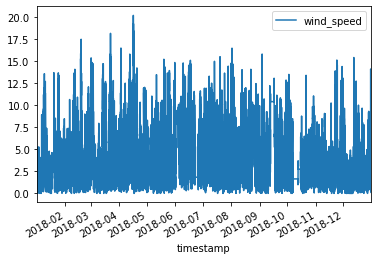

In [72]:
data_SnakeRESalt.plot()

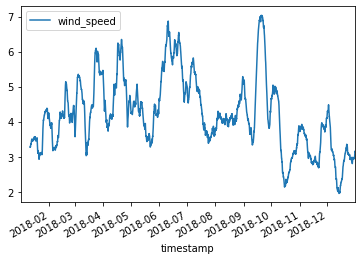

In [73]:
dataSnakeRESalt_mean = data_SnakeRESalt.rolling(window = 1500).mean()
dataSnakeRESalt_mean.plot()

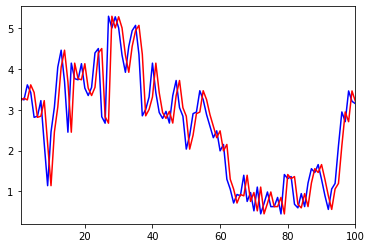

In [75]:
#Use the persistence model as a baseline model
#The first step is to load the dataset and create a lagged representation. 
#That is, given the observation at t-1, predict the observation at t+1
series_DataSnakeRESalt_value = data_SnakeRESalt.values
value_DataSnakeRESalt = pd.DataFrame(series_DataSnakeRESalt_value)
#persistence model
#dataframe.shift
wind_speed6 = pd.concat([value_DataSnakeRESalt, value_DataSnakeRESalt.shift(1)], axis = 1)
wind_speed6.columns = (['Actual', 'Predicted'])
windspeed_DataSnakeRESalt = wind_speed6[1:]

#plots of actual and predicted values
windspeed_DataSnakeRESalt['Actual'].head(100).plot(color='blue')
windspeed_DataSnakeRESalt['Predicted'].head(100).plot(color='red')

In [76]:
#persistence model mean squared error, root mean squared error, and mean absolute error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

windError_DataSnakeRESalt = mean_squared_error(windspeed_DataSnakeRESalt['Actual'], windspeed_DataSnakeRESalt['Predicted'])
mae_DataSnakeRESalt = mean_absolute_error(windspeed_DataSnakeRESalt['Actual'], windspeed_DataSnakeRESalt['Predicted'])
print("Mean squared error is: ", windError_DataSnakeRESalt)
print("Root mean squared error is: ", np.sqrt(windError_DataSnakeRESalt))
print("Mean absolute error is: ", mae_DataSnakeRESalt)

Mean squared error is:  0.8682344939942582
Root mean squared error is:  0.9317910141197211
Mean absolute error is:  0.6362965891338643


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


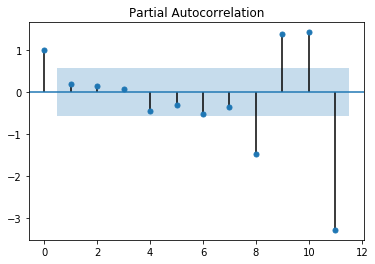

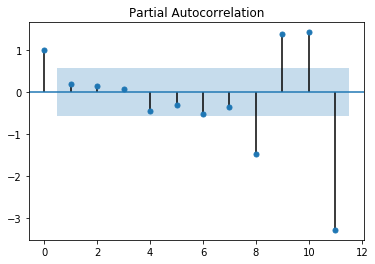

In [77]:
from statsmodels.graphics.tsaplots import plot_pacf

#Auto Regressive Model: A Stage of ARIMA implementation
#pacf is used to find the value of p
#find the value of p
#only one point is not in the critical portion

#resampling the data month-wise gives the lowest error
resampledData_SnakeRESalt = data_SnakeRESalt.resample('M').mean()
plot_pacf(resampledData_SnakeRESalt)

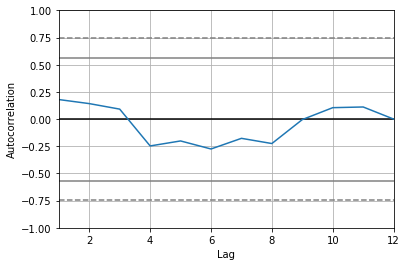

In [78]:
#Moving Average Model: A Stage of ARIMA implementation

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

#acf is used to find the value of q
autocorrelation_plot(resampledData_SnakeRESalt)
#from the graph below the value of q is zero (no point is above the critical line)

In [79]:
#ARIMA model implementation
#d is the value where the data gets stationary
from statsmodels.tsa.arima_model import ARIMA

#parameter tuning
#from the previous AR and MA plots and knowing that our data is stationary, pdq values will be (1,0,0) respectively
modelData_SnakeRESalt = ARIMA(resampledData_SnakeRESalt, order = (1,0,0))
modelFitData_SnakeRESalt = modelData_SnakeRESalt.fit(disp = 0)
#residual error is observed minus predicted
residualsData_SnakeRESalt = pd.DataFrame(modelFitData_SnakeRESalt.resid)

forecastedData_SnakeRESalt = modelFitData_SnakeRESalt.forecast(steps = len(resampledData_SnakeRESalt))[0]
predictionsData_SnakeRESalt = pd.DataFrame(forecastedData_SnakeRESalt)
predictionsData_SnakeRESalt.columns = ['predictions']
predData_SnakeRESalt = pd.DataFrame(predictionsData_SnakeRESalt.values)
actualData_SnakeRESalt = pd.DataFrame(resampledData_SnakeRESalt.wind_speed.values)
predData_SnakeRESalt.columns = ['predicted']
actualData_SnakeRESalt.columns = ['actual']
f_predictionsData_SnakeRESalt = pd.merge(actualData_SnakeRESalt, predData_SnakeRESalt, left_index = True, right_index = True)
#Actual vs. Predicted
print(f_predictionsData_SnakeRESalt)

      actual  predicted
0   3.491393   3.850814
1   3.960881   4.081301
2   4.876020   4.134622
3   4.930931   4.146958
4   4.158636   4.149811
5   5.881553   4.150471
6   4.169876   4.150624
7   4.370037   4.150660
8   5.074353   4.150668
9   3.244395   4.150670
10  3.383979   4.150670
11  2.854514   4.150670


In [80]:
from sklearn.metrics import mean_absolute_error

errorData_SnakeRESalt = mean_squared_error(predictionsData_SnakeRESalt.values, resampledData_SnakeRESalt.wind_speed.values)
maeData_SnakeRESalt = mean_absolute_error(f_predictionsData_SnakeRESalt.actual, f_predictionsData_SnakeRESalt.predicted)
print("The Mean Squared Error is: ", errorData_SnakeRESalt)
print("The Root Mean Squared Error is: ", np.sqrt(errorData_SnakeRESalt))
print("The Mean Absolute Error is: ", maeData_SnakeRESalt)

The Mean Squared Error is:  0.6912958994217048
The Root Mean Squared Error is:  0.8314420601711852
The Mean Absolute Error is:  0.6563795096086761


In [81]:
df_SnakeRESage = pd.read_csv(io.BytesIO(uploadtrain['Snake Range East Sagebrush.csv']))
df_SnakeRESage.columns = ['timestamp', 'wind_speed']

#Convert the timestamp to actual date time data type
time = pd.to_datetime(df_SnakeRESage.timestamp)
data_SnakeRESage = pd.DataFrame(time)
data_SnakeRESage['wind_speed'] = df_SnakeRESage['wind_speed']
data_SnakeRESage = data_SnakeRESage.set_index(['timestamp'])
data_SnakeRESage.head()

,wind_speed
timestamp,
2018-01-01 00:10:00-08:00,1.712163
2018-01-01 00:20:00-08:00,1.074684
2018-01-01 00:30:00-08:00,0.727781
2018-01-01 00:40:00-08:00,1.406388
2018-01-01 00:50:00-08:00,1.852087


In [82]:
print(data_SnakeRESage.describe())

         wind_speed
count  47987.000000
mean       3.458900
std        2.228762
min        0.000000
25%        1.869074
50%        2.987568
75%        4.530750
max       21.623325


In [83]:
data_SnakeRESage = data_SnakeRESage.replace('?',np.NaN)

print('Number of instances = %d' % (data_SnakeRESage.shape[0]))
print('Number of attributes = %d' % (data_SnakeRESage.shape[1]))

print('Number of missing values:')
for col in data_SnakeRESage.columns:
    print('\t%s: %d' % (col, data_SnakeRESage[col].isna().sum()))

Number of instances = 52487
Number of attributes = 1
Number of missing values:
	wind_speed: 4500


In [84]:
data_SnakeRESage =  data_SnakeRESage.fillna(method = 'ffill')
print(data_SnakeRESage.describe())

         wind_speed
count  52487.000000
mean       3.515084
std        2.189304
min        0.000000
25%        1.911990
50%        3.072953
75%        4.617923
max       21.623325


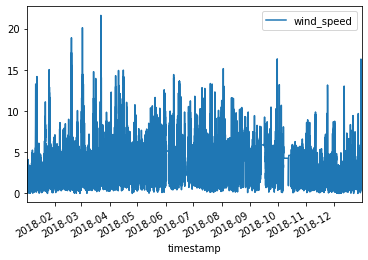

In [85]:
data_SnakeRESage.plot()

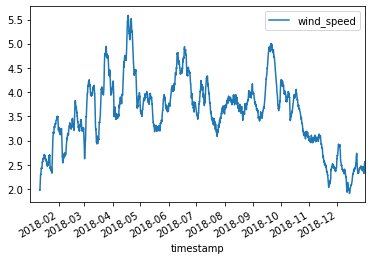

In [86]:
dataSnakeRESage_mean = data_SnakeRESage.rolling(window = 1500).mean()
dataSnakeRESage_mean.plot()

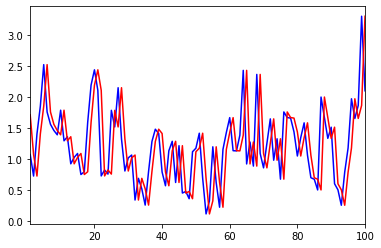

In [87]:
#Use the persistence model as a baseline model
#The first step is to load the dataset and create a lagged representation. 
#That is, given the observation at t-1, predict the observation at t+1
series_DataSnakeRESage_value = data_SnakeRESage.values
value_DataSnakeRESage = pd.DataFrame(series_DataSnakeRESage_value)
#persistence model
#dataframe.shift
wind_speed7 = pd.concat([value_DataSnakeRESage, value_DataSnakeRESage.shift(1)], axis = 1)
wind_speed7.columns = (['Actual', 'Predicted'])
windspeed_DataSnakeRESage = wind_speed7[1:]

#Plots of actual and predicted values
windspeed_DataSnakeRESage['Actual'].head(100).plot(color='blue')
windspeed_DataSnakeRESage['Predicted'].head(100).plot(color='red')

In [88]:
#persistence model mean squared error, root mean squared error, and mean absolute error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

windError_DataSnakeRESage = mean_squared_error(windspeed_DataSnakeRESage['Actual'], windspeed_DataSnakeRESage['Predicted'])
mae_DataSnakeRESage = mean_absolute_error(windspeed_DataSnakeRESage['Actual'], windspeed_DataSnakeRESage['Predicted'])
print("Mean squared error is: ", windError_DataSnakeRESage)
print("Root mean squared error is: ", np.sqrt(windError_DataSnakeRESage))
print("Mean absolute error is: ", mae_DataSnakeRESage)

Mean squared error is:  0.7466004589664695
Root mean squared error is:  0.864060448676173
Mean absolute error is:  0.587480793811683


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


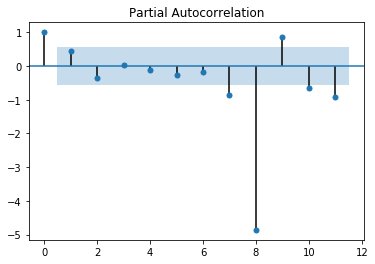

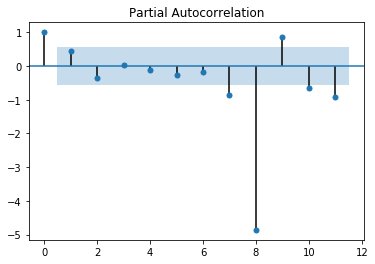

In [89]:
from statsmodels.graphics.tsaplots import plot_pacf

#Auto Regressive Model: A Stage of ARIMA implementation
#pacf is used to find the value of p
#find the value of p
#only one point is not in the critical portion

#resampling the data month-wise gives the lowest error
resampledData_SnakeRESage = data_SnakeRESage.resample('M').mean()
plot_pacf(resampledData_SnakeRESage)

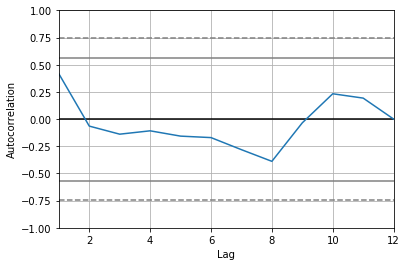

In [90]:
#Moving Average Model: A Stage of ARIMA implementation

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

#acf is used to find the value of q
autocorrelation_plot(resampledData_SnakeRESage)
#from the graph below the value of q is zero (no point is above the critical line)

In [91]:
#ARIMA model implementation
#d is the value where the data gets stationary
from statsmodels.tsa.arima_model import ARIMA

#parameter tuning
#from the previous AR and MA plots and knowing that our data is stationary, pdq values will be (1,0,0) respectively
modelData_SnakeRESage = ARIMA(resampledData_SnakeRESage, order = (1,0,0))
modelFitData_SnakeRESage = modelData_SnakeRESage.fit(disp = 0)
#residual error is observed minus predicted
residualsData_SnakeRESage = pd.DataFrame(modelFitData_SnakeRESage.resid)

forecastedData_SnakeRESage = modelFitData_SnakeRESage.forecast(steps = len(resampledData_SnakeRESage))[0]
predictionsData_SnakeRESage = pd.DataFrame(forecastedData_SnakeRESage)
predictionsData_SnakeRESage.columns = ['predictions']
predData_SnakeRESage = pd.DataFrame(predictionsData_SnakeRESage.values)
actualData_SnakeRESage = pd.DataFrame(resampledData_SnakeRESage.wind_speed.values)
predData_SnakeRESage.columns = ['predicted']
actualData_SnakeRESage.columns = ['actual']
f_predictionsData_SnakeRESage = pd.merge(actualData_SnakeRESage, predData_SnakeRESage, left_index = True, right_index = True)
#Actual vs. Predicted
print(f_predictionsData_SnakeRESage)

      actual  predicted
0   2.629856   2.718619
1   3.123769   2.930826
2   4.103344   3.064432
3   4.311843   3.148550
4   3.636671   3.201511
5   4.230179   3.234855
6   3.710846   3.255848
7   3.779240   3.269065
8   4.271714   3.277387
9   3.343743   3.282626
10  2.647058   3.285925
11  2.381568   3.288002


In [92]:
from sklearn.metrics import mean_absolute_error

errorData_SnakeRESage = mean_squared_error(predictionsData_SnakeRESage.values, resampledData_SnakeRESage.wind_speed.values)
maeData_SnakeRESage = mean_absolute_error(f_predictionsData_SnakeRESage.actual, f_predictionsData_SnakeRESage.predicted)
print("The Mean Squared Error is: ", errorData_SnakeRESage)
print("The Root Mean Squared Error is: ", np.sqrt(errorData_SnakeRESage))
print("The Mean Absolute Error is: ", maeData_SnakeRESage)

The Mean Squared Error is:  0.5289353704042498
The Root Mean Squared Error is:  0.7272794307583913
The Mean Absolute Error is:  0.6233592418077128


In [93]:
df_SheepRJuniper = pd.read_csv(io.BytesIO(uploadtrain['Sheep Range Pinyon-Juniper.csv']))
df_SheepRJuniper.columns = ['timestamp', 'wind_speed']

#Convert the timestamp to actual date time data type
time = pd.to_datetime(df_SheepRJuniper.timestamp)
data_SheepRJuniper = pd.DataFrame(time)
data_SheepRJuniper['wind_speed'] = df_SheepRJuniper['wind_speed']
data_SheepRJuniper = data_SheepRJuniper.set_index(['timestamp'])
data_SheepRJuniper.head()

,wind_speed
timestamp,
2018-01-01 00:10:00-08:00,3.038978
2018-01-01 00:20:00-08:00,4.260291
2018-01-01 00:30:00-08:00,3.907130
2018-01-01 00:40:00-08:00,3.233887
2018-01-01 00:50:00-08:00,2.953146


In [94]:
print(data_SheepRJuniper.describe())

         wind_speed
count  48271.000000
mean       2.740846
std        1.363616
min        0.000000
25%        1.813641
50%        2.612055
75%        3.463666
max       11.091062


In [95]:
data_SheepRJuniper = data_SheepRJuniper.replace('?',np.NaN)

print('Number of instances = %d' % (data_SheepRJuniper.shape[0]))
print('Number of attributes = %d' % (data_SheepRJuniper.shape[1]))

print('Number of missing values:')
for col in data_SheepRJuniper.columns:
    print('\t%s: %d' % (col, data_SheepRJuniper[col].isna().sum()))

Number of instances = 52487
Number of attributes = 1
Number of missing values:
	wind_speed: 4216


In [96]:
data_SheepRJuniper =  data_SheepRJuniper.fillna(method = 'ffill')
print(data_SheepRJuniper.describe())

         wind_speed
count  52487.000000
mean       2.799227
std        1.411632
min        0.000000
25%        1.826382
50%        2.658547
75%        3.502111
max       11.091062


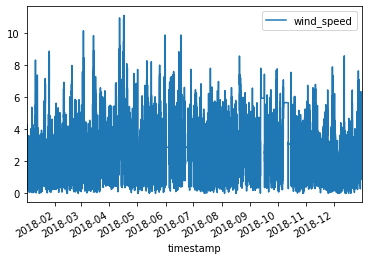

In [97]:
data_SheepRJuniper.plot()

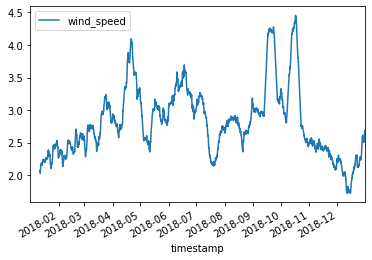

In [98]:
dataSheepRJuniper_mean = data_SheepRJuniper.rolling(window = 1500).mean()
dataSheepRJuniper_mean.plot()

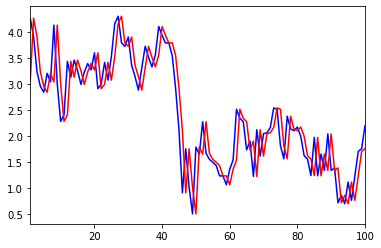

In [99]:
#Use the persistence model as a baseline model
#The first step is to load the dataset and create a lagged representation. 
#That is, given the observation at t-1, predict the observation at t+1
series_DataSheepRJuniper_value = data_SheepRJuniper.values
value_DataSheepRJuniper = pd.DataFrame(series_DataSheepRJuniper_value)
#persistence model
#dataframe.shift
wind_speed8 = pd.concat([value_DataSheepRJuniper, value_DataSheepRJuniper.shift(1)], axis = 1)
wind_speed8.columns = (['Actual', 'Predicted'])
windspeed_DataSheepRJuniper = wind_speed8[1:]

#plots of actual and predicted values
windspeed_DataSheepRJuniper['Actual'].head(100).plot(color='blue')
windspeed_DataSheepRJuniper['Predicted'].head(100).plot(color='red')

In [100]:
#persistence model mean squared error, root mean squared error, and mean absolute error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

windError_DataSheepRJuniper = mean_squared_error(windspeed_DataSheepRJuniper['Actual'], windspeed_DataSheepRJuniper['Predicted'])
mae_DataSheepRJuniper = mean_absolute_error(windspeed_DataSheepRJuniper['Actual'], windspeed_DataSheepRJuniper['Predicted'])
print("Mean squared error is: ", windError_DataSheepRJuniper)
print("Root mean squared error is: ", np.sqrt(windError_DataSheepRJuniper))
print("Mean absolute error is: ", mae_DataSheepRJuniper)

Mean squared error is:  0.3251290389454347
Root mean squared error is:  0.5702008759598978
Mean absolute error is:  0.40906854879701243


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


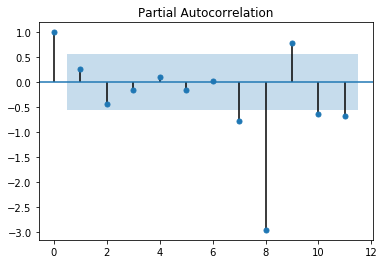

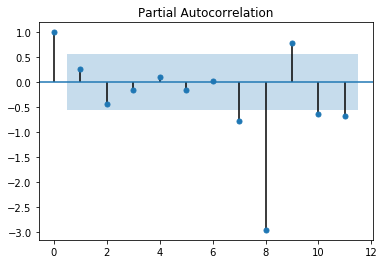

In [101]:
from statsmodels.graphics.tsaplots import plot_pacf

#Auto Regressive Model: A Stage of ARIMA implementation
#pacf is used to find the value of p
#find the value of p
#only one point is not in the critical portion

#resampling the data month-wise gives the lowest error
resampledData_SheepRJuniper = data_SheepRJuniper.resample('M').mean()
plot_pacf(resampledData_SheepRJuniper)

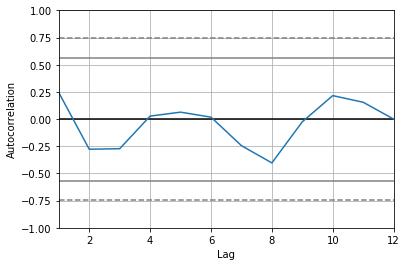

In [102]:
#Moving Average Model: A Stage of ARIMA implementation

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

#acf is used to find the value of q
autocorrelation_plot(resampledData_SheepRJuniper)
#from the graph below the value of q is zero (no point is above the critical line)

In [103]:
#ARIMA model implementation
#d is the value where the data gets stationary
from statsmodels.tsa.arima_model import ARIMA

#parameter tuning
#from the previous AR and MA plots and knowing that our data is stationary, pdq values will be (1,0,0) respectively
modelData_SheepRJuniper = ARIMA(resampledData_SheepRJuniper, order = (1,0,0))
modelFitData_SheepRJuniper = modelData_SheepRJuniper.fit(disp = 0)
#residual error is observed minus predicted
residualsData_SheepRJuniper = pd.DataFrame(modelFitData_SheepRJuniper.resid)

forecastedData_SheepRJuniper = modelFitData_SheepRJuniper.forecast(steps = len(resampledData_SheepRJuniper))[0]
predictionsData_SheepRJuniper = pd.DataFrame(forecastedData_SheepRJuniper)
predictionsData_SheepRJuniper.columns = ['predictions']
predData_SheepRJuniper = pd.DataFrame(predictionsData_SheepRJuniper.values)
actualData_SheepRJuniper = pd.DataFrame(data_SheepRJuniper.wind_speed.values)
predData_SheepRJuniper.columns = ['predicted']
actualData_SheepRJuniper.columns = ['actual']
f_predictionsData_SheepRJuniper = pd.merge(actualData_SheepRJuniper, predData_SheepRJuniper, left_index = True, right_index = True)
#Actual vs. Predicted
print(f_predictionsData_SheepRJuniper)

      actual  predicted
0   3.038978   2.577417
1   4.260291   2.695990
2   3.907130   2.735418
3   3.233887   2.748528
4   2.953146   2.752888
5   2.836916   2.754337
6   3.201253   2.754819
7   3.036743   2.754980
8   4.126179   2.755033
9   3.002768   2.755051
10  2.278116   2.755057
11  2.404628   2.755058


In [104]:
from sklearn.metrics import mean_absolute_error

errorData_SheepRJuniper = mean_squared_error(predictionsData_SheepRJuniper.values, resampledData_SheepRJuniper.wind_speed.values)
maeData_SheepRJuniper = mean_absolute_error(f_predictionsData_SheepRJuniper.actual, f_predictionsData_SheepRJuniper.predicted)
print("The Mean Squared Error is: ", errorData_SheepRJuniper)
print("The Root Mean Squared Error is: ", np.sqrt(errorData_SheepRJuniper))
print("The Mean Absolute Error is: ", maeData_SheepRJuniper)

The Mean Squared Error is:  0.1636046973551862
The Root Mean Squared Error is:  0.4044807750130854
The Mean Absolute Error is:  0.5950167608139365


In [105]:
df_SheepRMontane = pd.read_csv(io.BytesIO(uploadtrain['Sheep Range Montane.csv']))
df_SheepRMontane.columns = ['timestamp', 'wind_speed']

#Convert the timestamp to actual date time data type
time = pd.to_datetime(df_SheepRMontane.timestamp)
data_SheepRMontane = pd.DataFrame(time)
data_SheepRMontane['wind_speed'] = df_SheepRMontane['wind_speed']
data_SheepRMontane = data_SheepRMontane.set_index(['timestamp'])
data_SheepRMontane.head()

,wind_speed
timestamp,
2018-01-01 00:10:00-08:00,2.589703
2018-01-01 00:20:00-08:00,2.473919
2018-01-01 00:30:00-08:00,1.882038
2018-01-01 00:40:00-08:00,1.730939
2018-01-01 00:50:00-08:00,1.825711


In [106]:
print(data_SheepRMontane.describe())

         wind_speed
count  48102.000000
mean       2.300193
std        1.634192
min        0.000000
25%        1.133693
50%        1.804477
75%        3.086811
max       12.888163


In [107]:
data_SheepRMontane = data_SheepRMontane.replace('?',np.NaN)

print('Number of instances = %d' % (data_SheepRMontane.shape[0]))
print('Number of attributes = %d' % (data_SheepRMontane.shape[1]))

print('Number of missing values:')
for col in data_SheepRMontane.columns:
    print('\t%s: %d' % (col, data_SheepRMontane[col].isna().sum()))

Number of instances = 52487
Number of attributes = 1
Number of missing values:
	wind_speed: 4385


In [108]:
data_SheepRMontane =  data_SheepRMontane.fillna(method = 'ffill')
print(data_SheepRMontane.describe())

         wind_speed
count  52487.000000
mean       2.365330
std        1.720200
min        0.000000
25%        1.131458
50%        1.817665
75%        3.196783
max       12.888163


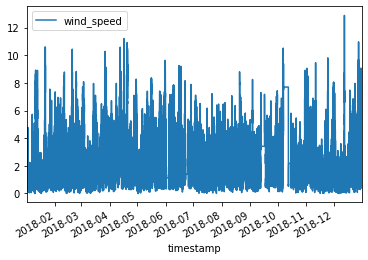

In [109]:
data_SheepRMontane.plot()

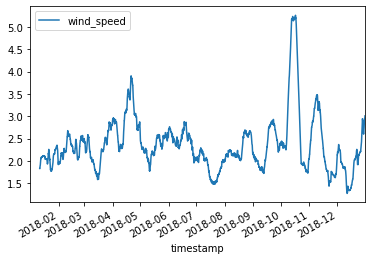

In [110]:
dataSheepRMontane_mean = data_SheepRMontane.rolling(window = 1500).mean()
dataSheepRMontane_mean.plot()

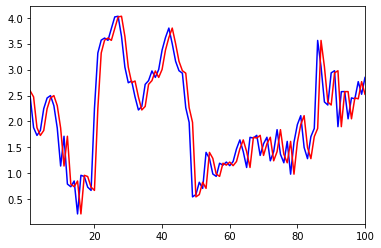

In [111]:
#Use the persistence model as a baseline model
#The first step is to load the dataset and create a lagged representation. 
#That is, given the observation at t-1, predict the observation at t+1
series_DataSheepRMontane_value = data_SheepRMontane.values
value_DataSheepRMontane = pd.DataFrame(series_DataSheepRMontane_value)
#persistence model
#dataframe.shift
wind_speed9 = pd.concat([value_DataSheepRMontane, value_DataSheepRMontane.shift(1)], axis = 1)
wind_speed9.columns = (['Actual', 'Predicted'])
windspeed_DataSheepRMontane = wind_speed9[1:]

#plots of actual and predicted values
windspeed_DataSheepRMontane['Actual'].head(100).plot(color='blue')
windspeed_DataSheepRMontane['Predicted'].head(100).plot(color='red')

In [112]:
#persistence model mean squared error, root mean squared error, and mean absolute error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

windError_DataSheepRMontane = mean_squared_error(windspeed_DataSheepRMontane['Actual'], windspeed_DataSheepRMontane['Predicted'])
mae_DataSheepRMontane = mean_absolute_error(windspeed_DataSheepRMontane['Actual'], windspeed_DataSheepRMontane['Predicted'])
print("Mean squared error is: ", windError_DataSheepRMontane)
print("Root mean squared error is: ", np.sqrt(windError_DataSheepRMontane))
print("Mean absolute error is: ", mae_DataSheepRMontane)

Mean squared error is:  0.376322378360902
Root mean squared error is:  0.613451202917479
Mean absolute error is:  0.4291803320961781


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


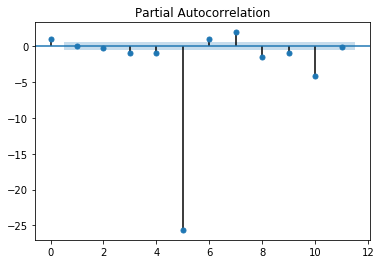

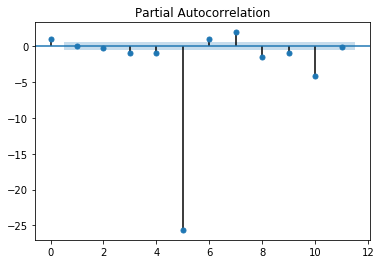

In [113]:
from statsmodels.graphics.tsaplots import plot_pacf

#Auto Regressive Model: A Stage of ARIMA implementation
#pacf is used to find the value of p
#find the value of p
#only one point is not in the critical portion

#resampling the data month-wise gives the lowest error
resampledData_SheepRMontane = data_SheepRMontane.resample('M').mean()
plot_pacf(resampledData_SheepRMontane)

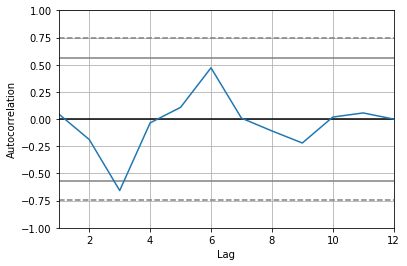

In [114]:
#Moving Average Model: A Stage of ARIMA implementation

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

#acf is used to find the value of q
autocorrelation_plot(resampledData_SheepRMontane)
#from the graph below the value of q is zero (no point is above the critical line)

In [115]:
#ARIMA model implementation
#d is the value where the data gets stationary
from statsmodels.tsa.arima_model import ARIMA

#parameter tuning
#from the previous AR and MA plots and knowing that our data is stationary, pdq values will be (1,0,0) respectively
modelData_SheepRMontane = ARIMA(resampledData_SheepRMontane, order = (1,0,0))
modelFitData_SheepRMontane = modelData_SheepRMontane.fit(disp = 0)
#residual error is observed minus predicted
residualsData_SheepRMontane = pd.DataFrame(modelFitData_SheepRMontane.resid)

forecastedData_SheepRMontane = modelFitData_SheepRMontane.forecast(steps = len(resampledData_SheepRMontane))[0]
predictionsData_SheepRMontane = pd.DataFrame(forecastedData_SheepRMontane)
predictionsData_SheepRMontane.columns = ['predictions']
predData_SheepRMontane = pd.DataFrame(predictionsData_SheepRMontane.values)
actualData_SheepRMontane = pd.DataFrame(resampledData_SheepRMontane.wind_speed.values)
predData_SheepRMontane.columns = ['predicted']
actualData_SheepRMontane.columns = ['actual']
f_predictionsData_SheepRMontane = pd.merge(actualData_SheepRMontane, predData_SheepRMontane, left_index = True, right_index = True)
#Actual vs. Predicted
print(f_predictionsData_SheepRMontane)

      actual  predicted
0   1.984051   2.353943
1   2.315908   2.362896
2   2.373051   2.363346
3   2.905501   2.363369
4   2.359243   2.363370
5   2.308289   2.363370
6   1.865999   2.363370
7   2.301871   2.363370
8   2.365175   2.363370
9   3.106494   2.363370
10  2.328969   2.363370
11  2.175893   2.363370


In [116]:
from sklearn.metrics import mean_absolute_error

errorData_SheepRMontane = mean_squared_error(predictionsData_SheepRMontane.values, resampledData_SheepRMontane.wind_speed.values)
maeData_SheepRMontane = mean_absolute_error(f_predictionsData_SheepRMontane.actual, f_predictionsData_SheepRMontane.predicted)
print("The Mean Squared Error is: ", errorData_SheepRMontane)
print("The Root Mean Squared Error is: ", np.sqrt(errorData_SheepRMontane))
print("The Mean Absolute Error is: ", maeData_SheepRMontane)

The Mean Squared Error is:  0.10631736703143983
The Root Mean Squared Error is:  0.32606344019445027
The Mean Absolute Error is:  0.21280002266680317


In [117]:
df_SheepRMojave = pd.read_csv(io.BytesIO(uploadtrain['Sheep Range Mojave Desert Shrub.csv']))
df_SheepRMojave.columns = ['timestamp', 'wind_speed']

#Convert the timestamp to actual date time data type
time = pd.to_datetime(df_SheepRMojave.timestamp)
data_SheepRMojave = pd.DataFrame(time)
data_SheepRMojave['wind_speed'] = df_SheepRMojave['wind_speed']
data_SheepRMojave = data_SheepRMojave.set_index(['timestamp'])
data_SheepRMojave.head()

,wind_speed
timestamp,
2018-01-01 00:10:00-08:00,2.500295
2018-01-01 00:20:00-08:00,3.508370
2018-01-01 00:30:00-08:00,3.266074
2018-01-01 00:40:00-08:00,3.364870
2018-01-01 00:50:00-08:00,3.179348


In [118]:
print(data_SheepRMojave.describe())

         wind_speed
count  45480.000000
mean       4.073649
std        2.573426
min        0.000000
25%        2.021515
50%        3.594202
75%        5.793638
max       18.887440


In [119]:
data_SheepRMojave = data_SheepRMojave.replace('?',np.NaN)

print('Number of instances = %d' % (data_SheepRMojave.shape[0]))
print('Number of attributes = %d' % (data_SheepRMojave.shape[1]))

print('Number of missing values:')
for col in data_SheepRMojave.columns:
    print('\t%s: %d' % (col, data_SheepRMojave[col].isna().sum()))

Number of instances = 52487
Number of attributes = 1
Number of missing values:
	wind_speed: 7007


In [120]:
data_SheepRMojave =  data_SheepRMojave.fillna(method = 'ffill')
print(data_SheepRMojave.describe())

         wind_speed
count  52487.000000
mean       4.035669
std        2.728296
min        0.000000
25%        1.790172
50%        3.436844
75%        5.887517
max       18.887440


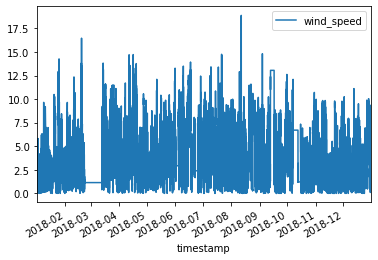

In [121]:
data_SheepRMojave.plot()

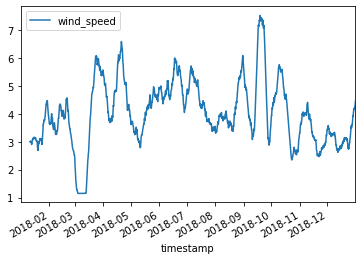

In [122]:
dataSheepRMojave_mean = data_SheepRMojave.rolling(window = 1500).mean()
dataSheepRMojave_mean.plot()

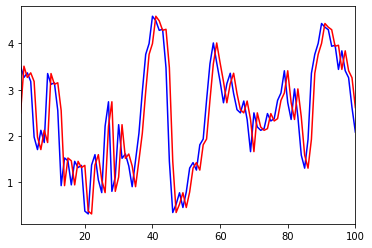

In [123]:
#Use the persistence model as a baseline model
#The first step is to load the dataset and create a lagged representation. 
#That is, given the observation at t-1, predict the observation at t+1
series_DataSheepRMojave_value = data_SheepRMojave.values
value_DataSheepRMojave = pd.DataFrame(series_DataSheepRMojave_value)
#persistence model
#dataframe.shift
wind_speed10 = pd.concat([value_DataSheepRMojave, value_DataSheepRMojave.shift(1)], axis = 1)
wind_speed10.columns = (['Actual', 'Predicted'])
windspeed_DataSheepRMojave = wind_speed10[1:]

#plots of actual and predicted values
windspeed_DataSheepRMojave['Actual'].head(100).plot(color='blue')
windspeed_DataSheepRMojave['Predicted'].head(100).plot(color='red')

In [124]:
#persistence model mean squared error, root mean squared error, and mean absolute error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

windError_DataSheepRMojave = mean_squared_error(windspeed_DataSheepRMojave['Actual'], windspeed_DataSheepRMojave['Predicted'])
mae_DataSheepRMojave = mean_absolute_error(windspeed_DataSheepRMojave['Actual'], windspeed_DataSheepRMojave['Predicted'])
print("Mean squared error is: ", windError_DataSheepRMojave)
print("Root mean squared error is: ", np.sqrt(windError_DataSheepRMojave))
print("Mean absolute error is: ", mae_DataSheepRMojave)

Mean squared error is:  0.49854849422844577
Root mean squared error is:  0.7060796656386911
Mean absolute error is:  0.47844390842510387


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


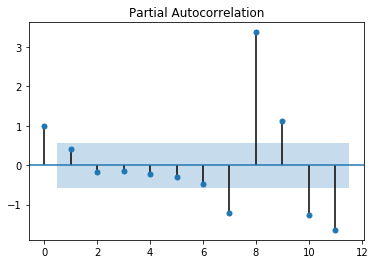

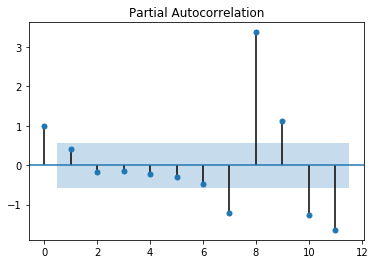

In [125]:
from statsmodels.graphics.tsaplots import plot_pacf

#Auto Regressive Model: A Stage of ARIMA implementation
#pacf is used to find the value of p
#find the value of p
#only one point is not in the critical portion

#resampling the data month-wise gives the lowest error
resampledData_SheepRMojave = data_SheepRMojave.resample('M').mean()
plot_pacf(resampledData_SheepRMojave)

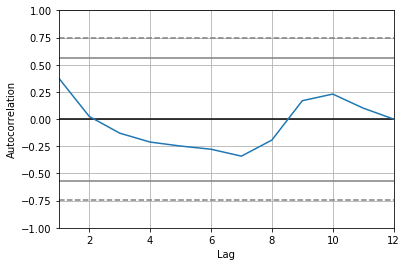

In [126]:
#Moving Average Model: A Stage of ARIMA implementation

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

#acf is used to find the value of q
autocorrelation_plot(resampledData_SheepRMojave)
#from the graph below the value of q is zero (no point is above the critical line)

In [127]:
#ARIMA model implementation
#d is the value where the data gets stationary
from statsmodels.tsa.arima_model import ARIMA

#parameter tuning
#from the previous AR and MA plots and knowing that our data is stationary, pdq values will be (1,0,0) respectively
modelData_SheepRMojave = ARIMA(resampledData_SheepRMojave, order = (1,0,0))
modelFitData_SheepRMojave = modelData_SheepRMojave.fit(disp = 0)
#residual error is observed minus predicted
residualsData_SheepRMojave = pd.DataFrame(modelFitData_SheepRMojave.resid)

forecastedData_SheepRMojave = modelFitData_SheepRMojave.forecast(steps = len(resampledData_SheepRMojave))[0]
predictionsData_SheepRMojave = pd.DataFrame(forecastedData_SheepRMojave)
predictionsData_SheepRMojave.columns = ['predictions']
predData_SheepRMojave = pd.DataFrame(predictionsData_SheepRMojave.values)
actualData_SheepRMojave = pd.DataFrame(resampledData_SheepRMojave.wind_speed.values)
predData_SheepRMojave.columns = ['predicted']
actualData_SheepRMojave.columns = ['actual']
f_predictionsData_SheepRMojave = pd.merge(actualData_SheepRMojave, predData_SheepRMojave, left_index = True, right_index = True)
#Actual vs. Predicted
print(f_predictionsData_SheepRMojave)

      actual  predicted
0   3.273175   3.730350
1   3.271525   3.855332
2   3.926671   3.910684
3   4.712695   3.935199
4   4.120613   3.946056
5   5.004516   3.950864
6   4.145017   3.952994
7   4.444463   3.953937
8   4.884090   3.954354
9   3.884889   3.954539
10  3.284874   3.954621
11  3.448146   3.954658


In [128]:
from sklearn.metrics import mean_absolute_error

errorData_SheepRMojave = mean_squared_error(predictionsData_SheepRMojave.values, resampledData_SheepRMojave.wind_speed.values)
maeData_SheepRMojave = mean_absolute_error(f_predictionsData_SheepRMojave.actual, f_predictionsData_SheepRMojave.predicted)
print("The Mean Squared Error is: ", errorData_SheepRMojave)
print("The Root Mean Squared Error is: ", np.sqrt(errorData_SheepRMojave))
print("The Mean Absolute Error is: ", maeData_SheepRMojave)

The Mean Squared Error is:  0.3455926603987427
The Root Mean Squared Error is:  0.5878712957771818
The Mean Absolute Error is:  0.4934057167950308


In [129]:
df_SheepRBlack = pd.read_csv(io.BytesIO(uploadtrain['Sheep Range Blackbrush.csv']))
df_SheepRBlack.columns = ['timestamp', 'wind_speed']

#Convert the timestamp to actual date time data type
time = pd.to_datetime(df_SheepRBlack.timestamp)
data_SheepRBlack = pd.DataFrame(time)
data_SheepRBlack['wind_speed'] = df_SheepRBlack['wind_speed']
data_SheepRBlack = data_SheepRBlack.set_index(['timestamp'])
data_SheepRBlack.head()

,wind_speed
timestamp,
2018-01-01 00:10:00-08:00,4.327347
2018-01-01 00:20:00-08:00,4.778858
2018-01-01 00:30:00-08:00,4.376522
2018-01-01 00:40:00-08:00,4.774387
2018-01-01 00:50:00-08:00,4.904029


In [130]:
print(data_SheepRBlack.describe())

         wind_speed
count  48499.000000
mean       3.754964
std        1.609502
min        0.000000
25%        2.749743
50%        3.714902
75%        4.532986
max       13.929766


In [131]:
data_SheepRBlack = data_SheepRBlack.replace('?',np.NaN)

print('Number of instances = %d' % (data_SheepRBlack.shape[0]))
print('Number of attributes = %d' % (data_SheepRBlack.shape[1]))

print('Number of missing values:')
for col in data_SheepRBlack.columns:
    print('\t%s: %d' % (col, data_SheepRBlack[col].isna().sum()))

Number of instances = 52487
Number of attributes = 1
Number of missing values:
	wind_speed: 3988


In [132]:
data_SheepRBlack =  data_SheepRBlack.fillna(method = 'ffill')
print(data_SheepRBlack.describe())

         wind_speed
count  52487.000000
mean       3.807834
std        1.618260
min        0.000000
25%        2.827081
50%        3.759606
75%        4.528515
max       13.929766


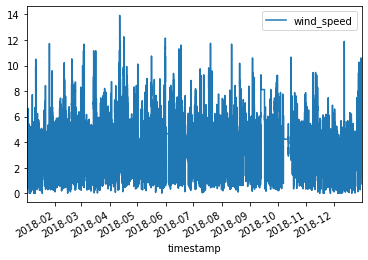

In [133]:
data_SheepRBlack.plot()

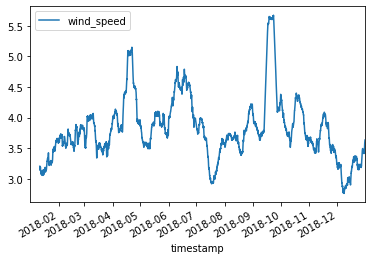

In [134]:
dataSheepRBlack_mean = data_SheepRBlack.rolling(window = 1500).mean()
dataSheepRBlack_mean.plot()

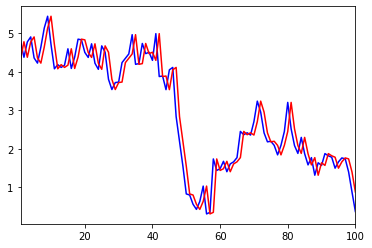

In [135]:
#Use the persistence model as a baseline model
#The first step is to load the dataset and create a lagged representation. 
#That is, given the observation at t-1, predict the observation at t+1
series_DataSheepRBlack_value = data_SheepRBlack.values
value_DataSheepRBlack = pd.DataFrame(series_DataSheepRBlack_value)
#persistence model
#dataframe.shift
wind_speed11 = pd.concat([value_DataSheepRBlack, value_DataSheepRBlack.shift(1)], axis = 1)
wind_speed11.columns = (['Actual', 'Predicted'])
windspeed_DataSheepRBlack = wind_speed11[1:]

#plots of actual and predicted values
windspeed_DataSheepRBlack['Actual'].head(100).plot(color='blue')
windspeed_DataSheepRBlack['Predicted'].head(100).plot(color='red')

In [136]:
#persistence model mean squared error, root mean squared error, and mean absolute error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

windError_DataSheepRBlack = mean_squared_error(windspeed_DataSheepRBlack['Actual'], windspeed_DataSheepRBlack['Predicted'])
mae_DataSheepRBlack = mean_absolute_error(windspeed_DataSheepRBlack['Actual'], windspeed_DataSheepRBlack['Predicted'])
print("Mean squared error is: ", windError_DataSheepRBlack)
print("Root mean squared error is: ", np.sqrt(windError_DataSheepRBlack))
print("Mean absolute error is: ", mae_DataSheepRBlack)

Mean squared error is:  0.44414691350586827
Root mean squared error is:  0.666443481103888
Mean absolute error is:  0.4745351148816827


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


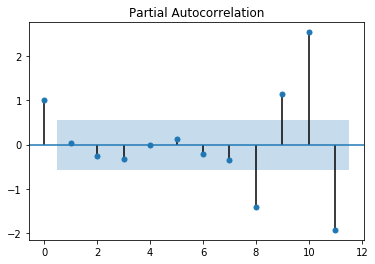

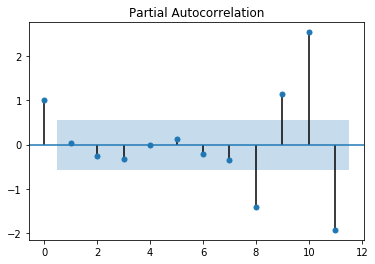

In [137]:
from statsmodels.graphics.tsaplots import plot_pacf

#Auto Regressive Model: A Stage of ARIMA implementation
#pacf is used to find the value of p
#find the value of p
#only one point is not in the critical portion

#resampling the data month-wise gives the lowest error
resampledData_SheepRBlack = data_SheepRBlack.resample('M').mean()
plot_pacf(resampledData_SheepRBlack)

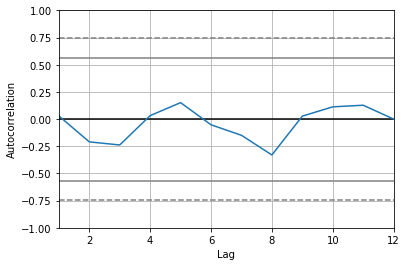

In [138]:
#Moving Average Model: A Stage of ARIMA implementation

from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

#acf is used to find the value of q
autocorrelation_plot(resampledData_SheepRBlack)
#from the graph below the value of q is zero (no point is above the critical line)

In [139]:
#ARIMA model implementation
#d is the value where the data gets stationary
from statsmodels.tsa.arima_model import ARIMA

#parameter tuning
#from the previous AR and MA plots and knowing that our data is stationary, pdq values will be (1,0,0) respectively
modelData_SheepRBlack = ARIMA(resampledData_SheepRBlack, order = (1,0,0))
modelFitData_SheepRBlack = modelData_SheepRBlack.fit(disp = 0)
#residual error is observed minus predicted
residualsData_SheepRBlack = pd.DataFrame(modelFitData_SheepRBlack.resid)

forecastedData_SheepRBlack = modelFitData_SheepRBlack.forecast(steps = len(resampledData_SheepRBlack))[0]
predictionsData_SheepRBlack = pd.DataFrame(forecastedData_SheepRBlack)
predictionsData_SheepRBlack.columns = ['predictions']
predData_SheepRBlack = pd.DataFrame(predictionsData_SheepRBlack.values)
actualData_SheepRBlack = pd.DataFrame(resampledData_SheepRBlack.wind_speed.values)
predData_SheepRBlack.columns = ['predicted']
actualData_SheepRBlack.columns = ['actual']
f_predictionsData_SheepRBlack = pd.merge(actualData_SheepRBlack, predData_SheepRBlack, left_index = True, right_index = True)
#Actual vs. Predicted
print(f_predictionsData_SheepRBlack)

      actual  predicted
0   3.355318   3.787936
1   3.656109   3.806119
2   3.789080   3.806801
3   4.285912   3.806826
4   3.849703   3.806827
5   4.300773   3.806827
6   3.423749   3.806827
7   3.801384   3.806827
8   4.600920   3.806827
9   3.819071   3.806827
10  3.533919   3.806827
11  3.303216   3.806827


In [140]:
from sklearn.metrics import mean_absolute_error

errorData_SheepRBlack = mean_squared_error(predictionsData_SheepRBlack.values, resampledData_SheepRBlack.wind_speed.values)
maeData_SheepRBlack = mean_absolute_error(f_predictionsData_SheepRBlack.actual, f_predictionsData_SheepRBlack.predicted)
print("The Mean Squared Error is: ", errorData_SheepRBlack)
print("The Root Mean Squared Error is: ", np.sqrt(errorData_SheepRBlack))
print("The Mean Absolute Error is: ", maeData_SheepRBlack)

The Mean Squared Error is:  0.14924446990067478
The Root Mean Squared Error is:  0.3863217181322774
The Mean Absolute Error is:  0.2989693696061675
